In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Plot settings
plt.rcParams['figure.figsize'] = (20, 15) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams.update({'font.size': 22})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define functions

In [6]:
def stft(x, fs, frame_size, hop):
  """
  Perform STFT (Short-Time Fourier Transform).

  x: Input data.
  fs: Sampling rate.
  frame_size: Frame size.
  hop: Hop size
  """

  frame_samp = int(frame_size*fs)
  hop_samp = int(hop*fs)
  w = np.hanning(frame_samp) # Hanning window
  X = np.array([np.fft.fft(w*x[i:i+frame_samp])
               for i in range(0, len(x)-frame_samp, hop_samp)])
  return X

def istft(X, fs, T, hop):
  """
  Perform inverse STFT (Short-Time Fourier Transform).

  X: Input data.
  fs: Sampling rate.
  T: Total time duration.
  hop: Hop size.
  """

  x = np.zeros(T*fs)
  frame_samp = X.shape[1]
  hop_samp = int(hop*fs)

  for n,i in enumerate(range(0, len(x)-frame_samp, hop_samp)):
    x[i:i+frame_samp] += np.real(np.fft.ifft(X[n]))

  return x


def simu_waves(f, dt, amp0=1, phi0=0):
  """
  Return the simulated waves.
  y(t) = amp0 * cos(phi(t) + phi0), 
  where phi(t) = 2 * pi * \int_0^t f(t) * dt. 
    
  f: Instantaneous frequencies.
  dt: Time interval.
  amp0: Amplitude.
  phi0: Initail phase. When it is -pi/2, sin waves are produced.  
  """
    
  phi = 2 * np.pi * np.cumsum(f) * dt
  y = amp0*np.cos(phi+ phi0)
    
  return y

def simu_freq_sawtooth(t, fm=1, B=1, fd=0, width=0.5):
    '''
    Simulated frequencies of sawtooth modulation.

    t: Time array.
    fm: Modulation frequency.
    fd: Doppler frequency shift.
    B: Bandwidth.
    '''
    f = B*0.5*(signal.sawtooth(2 * np.pi * fm * t, width=width) + 1)
    f += fd
    return f

### Employ the STFT to perform time-frequency analysis.

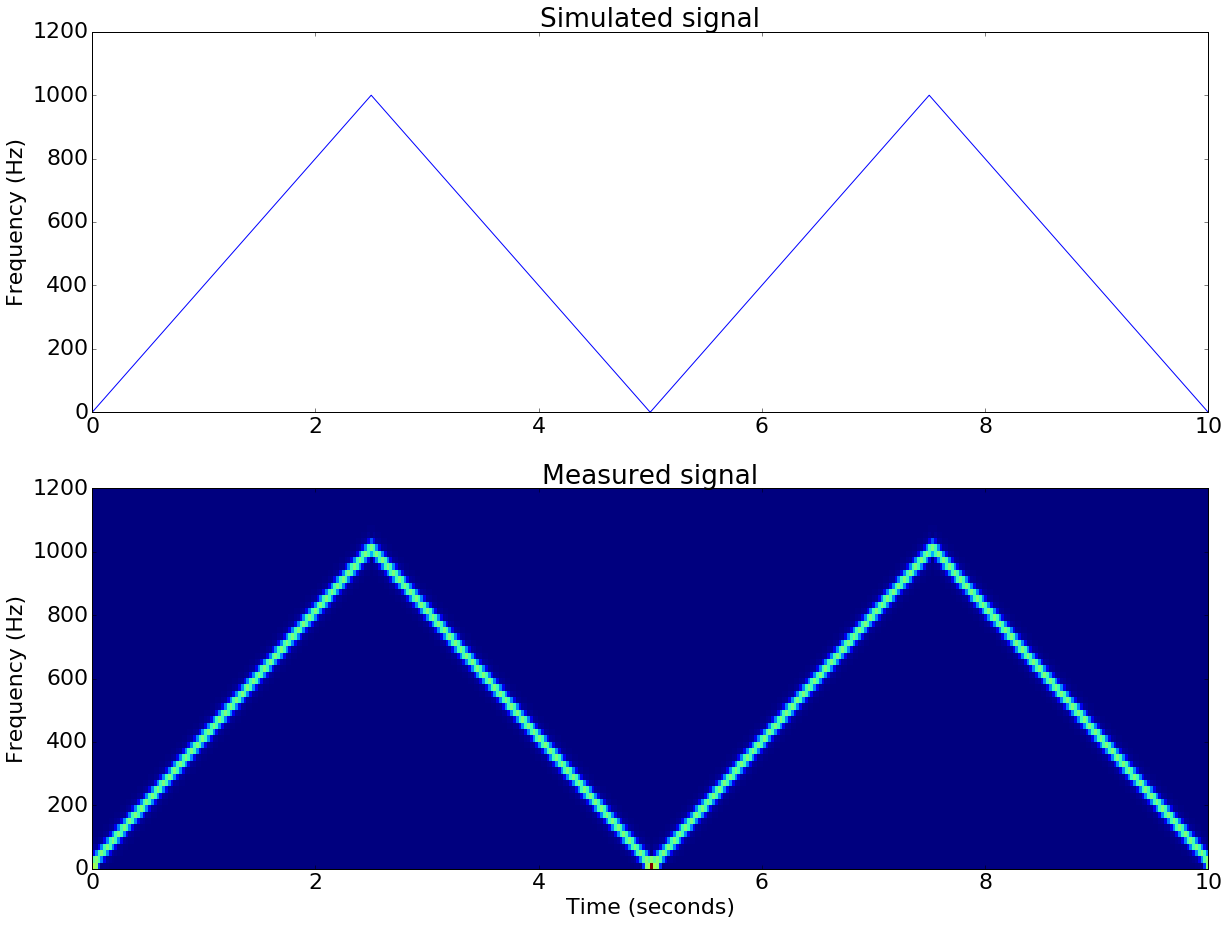

In [7]:
T = 10    # Time duration in (second)
fs = 4000 # Sampling rate (Hz)
fm = 0.2  # Frequency of modulation (Hz)
B = 1000  # Bandwidth (Hz)

frame_size = 0.050  # with a frame size of 50 milliseconds
hop = 0.025         # and hop size of 25 milliseconds.
    
t = np.linspace(0, T, T*fs, endpoint=False)
dt = t[1] - t[0]
f = simu_freq_sawtooth(t, fm, B, fd=0, width=0.5)
y = simu_waves(f, dt, amp0=1)      
Y = stft(y, fs, frame_size, hop)

# Plot time-frequency relation
t_min = t[0]
t_max = t[-1]
f_min = 0
f_max = int(fs * 0.3)

plt.figure(figsize=(20, 15))

ax = plt.subplot(2, 1, 1)
plt.plot(t, f)
plt.title('Simulated signal')
plt.ylim(t_min, t_max)
plt.ylim(f_min, f_max)
plt.ylabel('Frequency (Hz)')

ax = plt.subplot(2, 1, 2)
Fz = int(frame_size * fs *0.3 )
ax.imshow(np.absolute(Y[:, :Fz].T), origin='lower', 
          aspect='auto', interpolation='nearest', extent=[t_min, t_max, f_min, f_max])
plt.title('Measured signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')


### Verify the correctness of the inverse STFT.

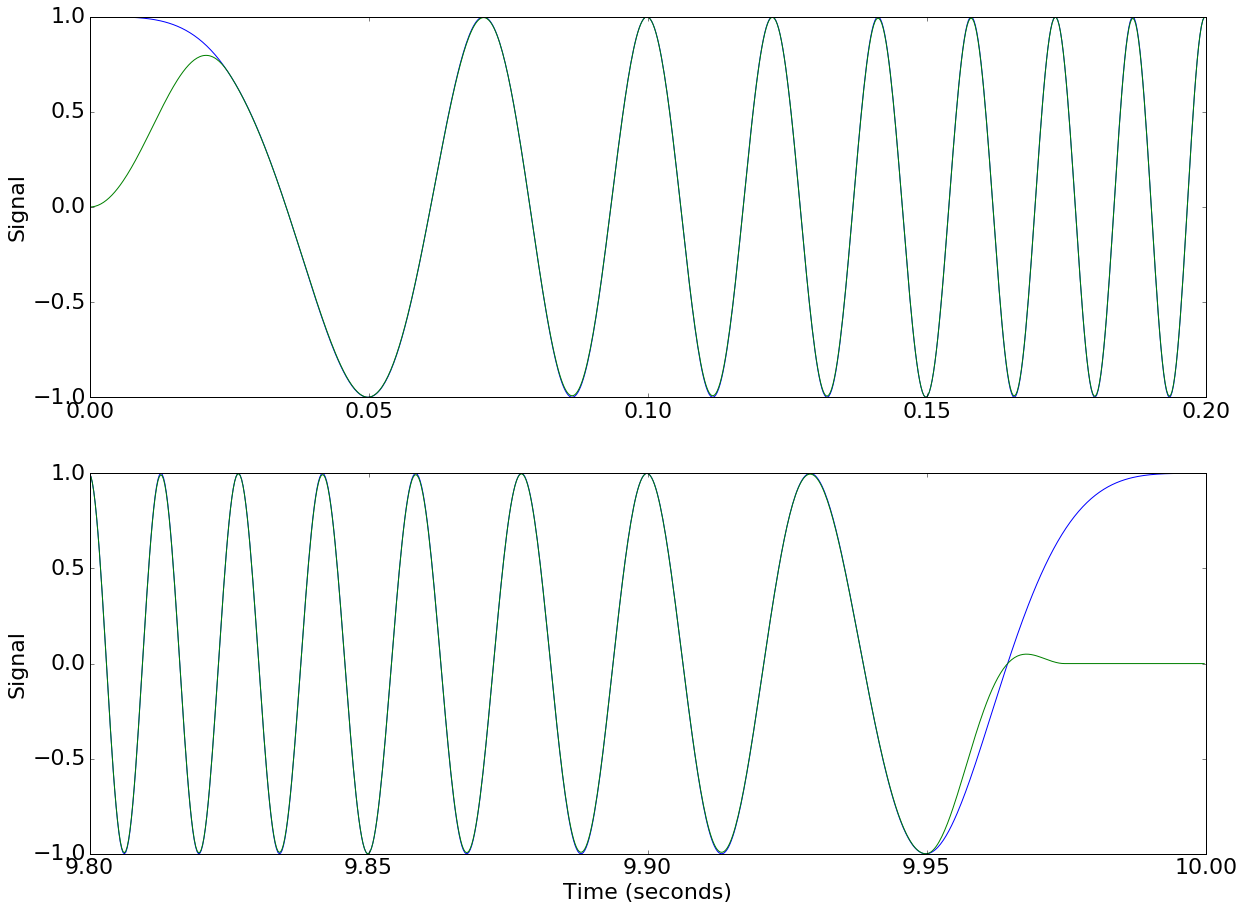

In [8]:
# Compute the ISTFT.
yhat = istft(Y, fs, T, hop)

# Plot partial sections of y(t) and yhat(t). They should be almost the same.
T1 = int(0.2*fs) # Sampling number within 0.2 seconds

plt.subplot(2, 1, 1)
plt.plot(t[:T1], y[:T1], t[:T1], yhat[:T1])
plt.ylabel('Signal')

plt.subplot(2, 1, 2)
plt.plot(t[-T1:], y[-T1:], t[-T1:], yhat[-T1:])
plt.ylabel('Signal')
plt.xlabel('Time (seconds)')
